# CIC Darknet 2020

We will be using the darknet dataset from Canada Institute of Cyber Security. Our goal is to work with the data to categorize darknet traffic. 

Steps we will take include:
1. Load data
2. Analyze data
   1. Cleaning the data
   2. Data Analysis
3. Visualize data
4. Split data into train-test set
5. Train and test a handful of models
6. Select the best model
7. Deploy the best model


# Importing Dataset


In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

To use the files in Google Collab, we need to follow these steps for each person.

1. Go to 'Shared with me/Cyber Research/Darknet' in your google drive
2. Right click the 'Experiments' Folder
3. Select 'Add shortcut to Drive'

This way, the code down below will work for you too!

In [2]:
!pwd
# Mounting your personal drive so we can use the csv file in our 'Code' folder
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Code'
%ls

/content
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1kC6SnjfhH2sLMBa10QWH927CWRlISCq2/Code
 cleaned_X.csv   Darknet.CSV     HyperTuning.ipynb
 cleaned_y.csv   darknet.ipynb  'Traffic Category Classifier.ipynb'


In [3]:
input = pd.read_csv('Darknet.CSV')

In [4]:
df = input

# Analyzing

In [5]:
# First look at the data 
df.head(5)

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,...,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,8733.624454,229.00000,0.00000,229,229,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,...,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1892,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4914.004914,407.00000,0.00000,407,407,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,...,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4640.371230,431.00000,0.00000,431,431,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,...,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,5571.030641,359.00000,0.00000,359,359,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,...,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,0,16.6475,46.833714,6604.75239,91.942711,10887.32424,11412.46641,78158,13,10778451,18268.56102,11786.14309,81171,126,10747836,26936.93233,15897.73845,78158,307,1,0,0,0,...,498,71.876008,56.93647,3241.761603,1,0,0,659,991,0,0,0,0,71.948537,109.187817,16.6475,0,0,0,0,659,6605,0,65,0,6,1382,2320,581,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING


In [6]:
# Here we can see the dimensions of the data
df.shape

(141530, 85)

In [7]:
# Showing a general stats for the data
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,141530.000000,141530.000000,141530.000000,1.415300e+05,141530.000000,141530.000000,1.415300e+05,1.415300e+05,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,1.414830e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,141530.000000,141530.0,141530.0,141530.0,1.415300e+05,1.415300e+05,1.415300e+05,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,1.415300e+05,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.0,141530.0,141530.0,141530.000000,141530.000000,141530.000000,141530.000000,141530.0,141530.0,141530.0,141530.0,141530.000000,1.415300e+05,141530.000000,141530.000000,141530.0,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.0,141530.0,141530.0,141530.0,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05
mean,38450.268819,18124.647333,10.350427,2.081280e+07,152.800749,154.642062,1.126211e+05,1.304530e+05,208.920420,15.617078,69.594959,63.974203,229.971299,41.252194,107.286657,65.183434,inf,inf,2.604871e+06,3.217701e+06,9.893961e+06,9.079030e+05,1.976846e+07,4.101510e+06,2.590150e+06,9.198071e+06,2.481004e+06,1.663278e+07,3.054588e+06,2.205417e+06,7.408141e+06,1.617510e+06,0.099562,0.0,0.0,0.0,2.933009e+03,3.099272e+03,6.321814e+03,4574.665230,14.365604,323.627316,94.373958,108.474093,5.488104e+04,0.455691,0.462284,0.038571,61.523168,268.251749,0.0,0.0,0.0,0.607214,108.900008,69.594959,107.286657,0.0,0.0,0.0,0.0,158.869455,4.521801e+04,0.286745,43.128022,0.0,55.488568,5308.189670,1766.762411,96.881573,15.808182,0.0,0.0,0.0,0.0,7.028030e+14,5.526137e+13,7.305885e+14,5.994078e+14
std,19124.801990,22202.197159,5.431807,3.809155e+07,2378.323352,3418.715287,3.251357e+06,4.566180e+06,649.432333,31.312298,219.965954,168.646012,786.736861,100.785013,240.511916,193.995126,NaN,NaN,7.124917e+06,7.753864e+06,1.968518e+07,5.665210e+06,3.765663e+07,1.145549e+07,7.138834e+06,1.921286e+07,1.049675e+07,3.590770e+07,1.036402e+07,6.824438e+06,1.801633e+07,9.098340e+06,0.299416,0.0,0.0,0.0,4.752686e+04,6.995175e+04,3.558899e+04,21380.969146,23.951595,966.025271,190.563975,207.640840,7.933552e+05,0.556133,0.844423,0.342543,807.239077,5342.816116,0.0,0.0,0.0,12.497544,197.306424,219.965954,240.511916,0.0,0.0,0.0,0.0,3042.371342,1.046669e+06,0.452243,137.725733,0.0,134.367698,9895.622577,7563.995687,1582.814902,7.110714,0.0,0.0,0.0,0.0,7.058710e+14,1.930165e+14,7.248202e+14,7.138287e+14
min,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00

In [8]:
# Let's see what we will be categorizing data into
print(df.groupby('Label').size())

Label
Non-Tor    93356
NonVPN     23863
Tor         1392
VPN        22919
dtype: int64


In [9]:
print(df.groupby('Label1').size())

Label1
AUDIO-STREAMING     1484
Audio-Streaming    16580
Browsing           32808
Chat               11478
Email               6145
File-Transfer      11098
File-transfer         84
P2P                48520
VOIP                3566
Video-Streaming     9486
Video-streaming      281
dtype: int64


# Cleaning


There are misspelling of data in Label1, so here we fix that. After that, we want relabel the classifing columns so it's easier to understand. 

In [10]:
df['Label1'] = df['Label1'].str.lower()
df.Label1.unique()

array(['audio-streaming', 'browsing', 'chat', 'email', 'file-transfer',
       'p2p', 'video-streaming', 'voip'], dtype=object)

If a column has only one unique value, we don't need to keep that. Here is how we removed those.

In [11]:
def DropSingleValueColumns():
    threshold = 1
    # get number of unique values for each column
    print(df.shape)
    for col in df.columns:  # Loop through columns
        if len(df[col].unique()) <= threshold:  # Find unique values in column along with their length and if len is == 1 then it contains same values
            df.drop([col], axis=1, inplace=True)  # Drop the column
    print(df.shape)

DropSingleValueColumns()

(141530, 85)
(141530, 70)


Next, we removed duplicated rows.

In [12]:
df.drop_duplicates(inplace=True)
print(df.shape)

(117073, 70)


Infinite numbers are excessive outliers, we want to remove those and NULL values.


In [13]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print(df.shape)

(117024, 70)


## X and y Separation

We need different dataframes for our data and labels

In [14]:
# We can use the 'apply' function in pandas to do this really easily

df['Label_dark'] = df['Label'].apply(lambda x: 1 if x == 'VPN' or 
                                     x == 'Tor' else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
y = df[['Label', 'Label1', 'Label_dark']]

In [16]:
# This will remove strings the strings from our X dataset

X = df.select_dtypes(exclude=object)
X = X.drop('Label_dark',axis=1)

In [17]:
X.shape

(117024, 64)

The data has classifications for Non-Tor or Tor combined with Non-VPN or VPN. When trying to classify what sort of traffic is in darknet, we want to combine VPN and Tor as "Darknet" with the rest being "Non-Darknet".

# Balancing

Here we can see our data is unbalanced. We can apply SMOTE(Synthetic Minority Over-sampling Technique)to overcome this. 

In [18]:
pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [19]:
# from imblearn.over_sampling import SMOTE

In [20]:
# sm = SMOTE(random_state=42)

# x_sm, y_sm = sm.fit_resample(X, y)

# print(f'''Shape of X before SMOTE: {X.shape}
# Shape of X after SMOTE: {x_sm.shape}''')

# print('\nBalance of positive and negative classes (%):')
# #y_sm.value_counts(normalize=True) * 100
# unique, counts = np.unique(y_sm, return_counts=True)

# dict(zip(unique, counts))

# Visualization 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline

Text(0.5, 0, 'Type of Traffic')

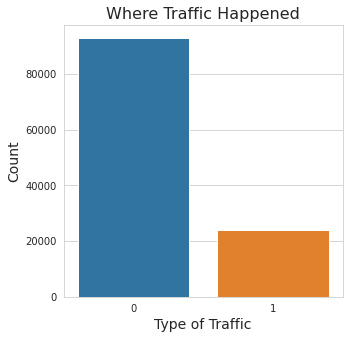

In [22]:
# Creating pandas series for count of label1

label3_count = df.Label_dark.value_counts()

plt.figure(figsize=(5,5))
sns.set_style('whitegrid')
plt.title('Where Traffic Happened', fontsize=16)
sns.barplot(x=label3_count.index, y=label3_count)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Type of Traffic', fontsize=14)

Text(0.5, 0, 'Type of Traffic')

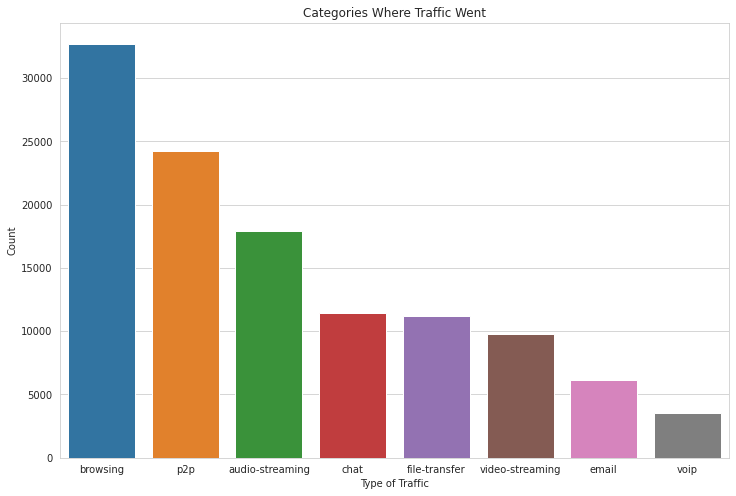

In [23]:
# Creating pandas series for count of label1
label1_count = df.Label1.value_counts()
label1_count

plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
plt.title('Categories Where Traffic Went')
sns.barplot(x=label1_count.index, y=label1_count)
plt.ylabel('Count')
plt.xlabel('Type of Traffic')

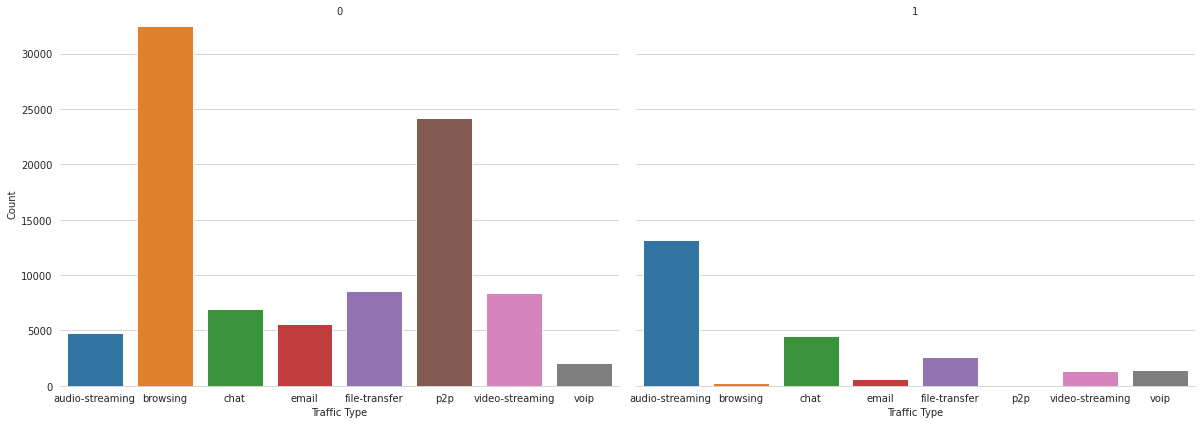

In [24]:
# Group plot of traffic depending on darknet or non-darknet

sns.set_style('whitegrid')
g = sns.catplot(x='Label1', col='Label_dark',
                data=df, kind='count', 
                height=6, aspect = 1.4)
(g.set_axis_labels("Traffic Type", "Count")
  .set_titles("{col_name}")
  .set(ylim=(0,33000))
  .despine(left=True))  

# Feature Selection

## Correlation Heatmap

Text(0.5, 1.0, 'Correlation Heatmap')

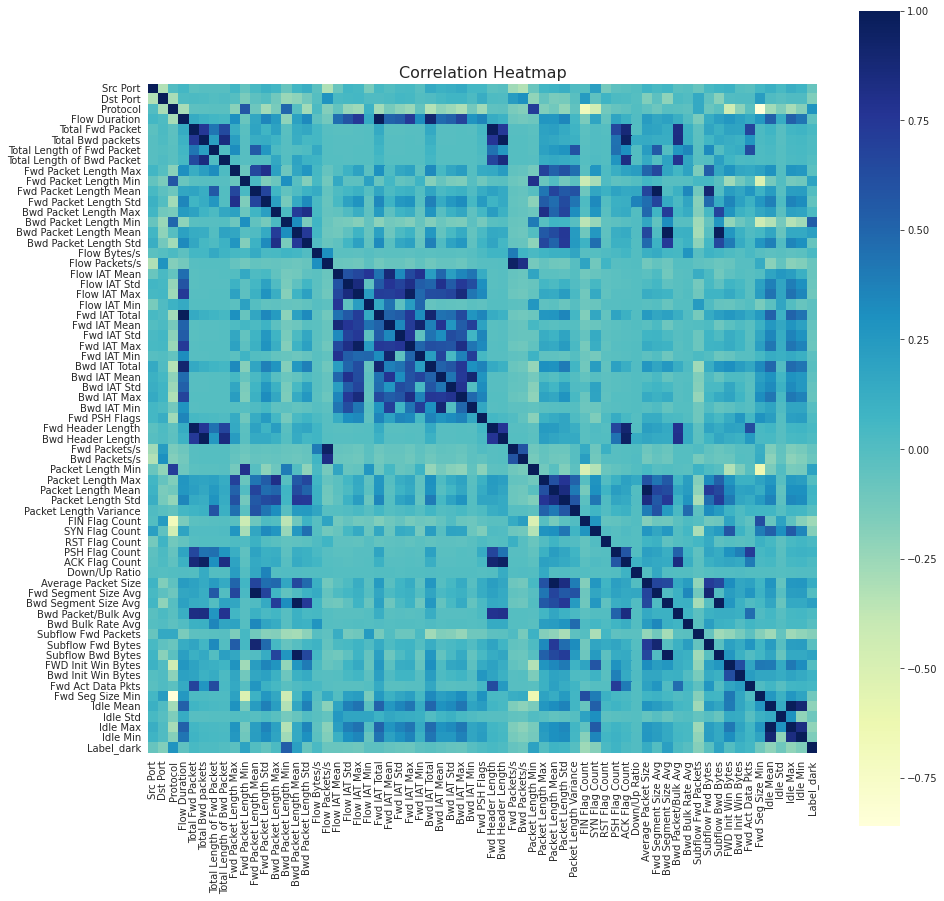

In [25]:
# Correllation

correlation = df.corr()
plt.figure(figsize =(15,15))
sns.heatmap(correlation, vmax=1, square=True, cmap='YlGnBu')
plt.title("Correlation Heatmap", fontsize=16)

## $X^2$ Test

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2

In [27]:
#splitting the data into feature (x) and target (y)

chi_X=X
chi_Y=y['Label_dark']

# Values must be equalized between 0 and 1
scaler = MinMaxScaler()
chi_X = pd.DataFrame( 
    scaler.fit_transform(chi_X), 
    columns=chi_X.columns 
)

# Fit model
chi_scores = chi2(chi_X, chi_Y)

# Retrieve the P-Scores for each feature
p_vals = pd.Series(chi_scores[1],index = chi_X.columns)

# Sort by lower to higher p-values 
p_vals.sort_values(ascending=True, inplace=True)

print("\t X^2 p-values")
# Print all p-values in ascending order base on p-value, if they are >0.5, then mark them as red
p_vals

	 X^2 p-values


Idle Min                       0.000000e+00
Dst Port                       0.000000e+00
Protocol                       0.000000e+00
Idle Max                       0.000000e+00
Idle Mean                      0.000000e+00
Subflow Fwd Packets            0.000000e+00
FIN Flag Count                 0.000000e+00
Bwd Packet Length Min          0.000000e+00
SYN Flag Count                4.554455e-195
Idle Std                      8.032302e-174
Bwd Init Win Bytes            4.291105e-130
Flow IAT Max                   7.219451e-81
Fwd IAT Max                    1.247691e-66
Subflow Bwd Bytes              2.802516e-61
Bwd Packet Length Mean         1.443896e-60
Bwd Segment Size Avg           1.443896e-60
Flow IAT Std                   2.609167e-45
Bwd IAT Max                    1.559651e-43
Fwd IAT Std                    4.050965e-41
Fwd Packet Length Min          1.420093e-39
PSH Flag Count                 4.128673e-37
Flow Duration                  2.678766e-33
Fwd IAT Mean                   2

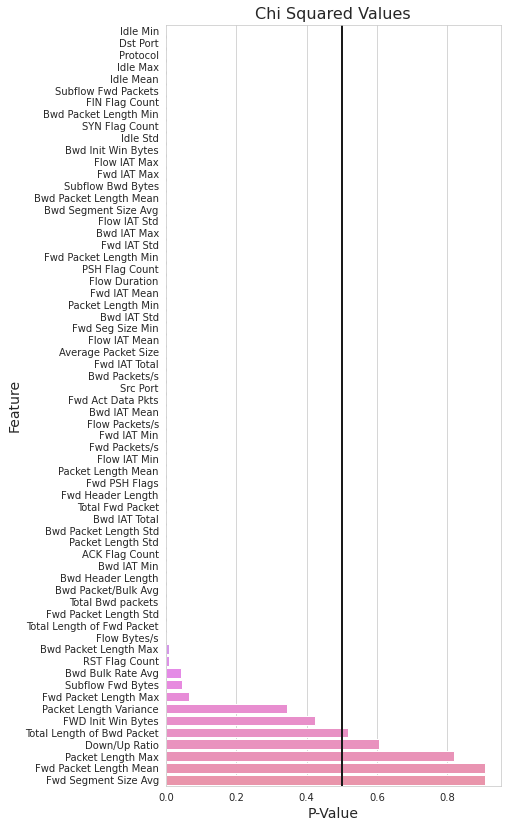

In [28]:
# visualize data
plt.figure(figsize=(6, 14))
plt.title('Chi Squared Values', fontsize=16)
plt.xlabel('P-Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.axvline(x=0.5,linewidth=2, color='k')
sns.set_theme(style="white")
sns.barplot(x=p_vals, y=p_vals.index)

## Pearson Correlation

In [29]:
from scipy.stats import pearsonr

In [30]:
# Stores the outcomes
pears_X = X.copy(deep=True)
pears_Y = y.copy(deep=True)
pears_Y = pears_Y['Label_dark']

# Calculate r-value for each feature
# Store results in a dictionary with the label and r-value
pears_dict = {}
for i in pears_X.columns:
  corr, _ = pearsonr(pears_X[i], pears_Y)
  pears_dict[pears_X[i].name] = corr

# Create data frames from the dictionaries
pears_X = pd.DataFrame.from_dict(pears_dict, orient='index')

# Rename the columns
pears_X.columns = ['r-value']

# Take the absolute value of all the r-values.
pears_X['r-value'] = pears_X['r-value'].abs()
pears_X.sort_values('r-value', inplace=True, ascending=False)
print('\t Pearson r-Values')
r_vals = pears_X.squeeze()
r_vals

	 Pearson r-Values


Bwd Packet Length Min         0.537420
Protocol                      0.280823
FIN Flag Count                0.259722
Idle Max                      0.216618
Bwd Segment Size Avg          0.210235
Bwd Packet Length Mean        0.210235
Idle Mean                     0.208922
Packet Length Min             0.197962
Subflow Bwd Bytes             0.191520
Fwd Packet Length Min         0.188425
SYN Flag Count                0.183470
Subflow Fwd Packets           0.179244
Dst Port                      0.165921
Idle Min                      0.156488
Average Packet Size           0.128951
Fwd Seg Size Min              0.110560
Idle Std                      0.099636
Bwd Init Win Bytes            0.098510
Flow IAT Max                  0.098340
Flow IAT Std                  0.088432
Bwd Packets/s                 0.088264
Fwd IAT Max                   0.087959
Fwd IAT Std                   0.082476
Flow Packets/s                0.079977
PSH Flag Count                0.079711
Flow IAT Mean            

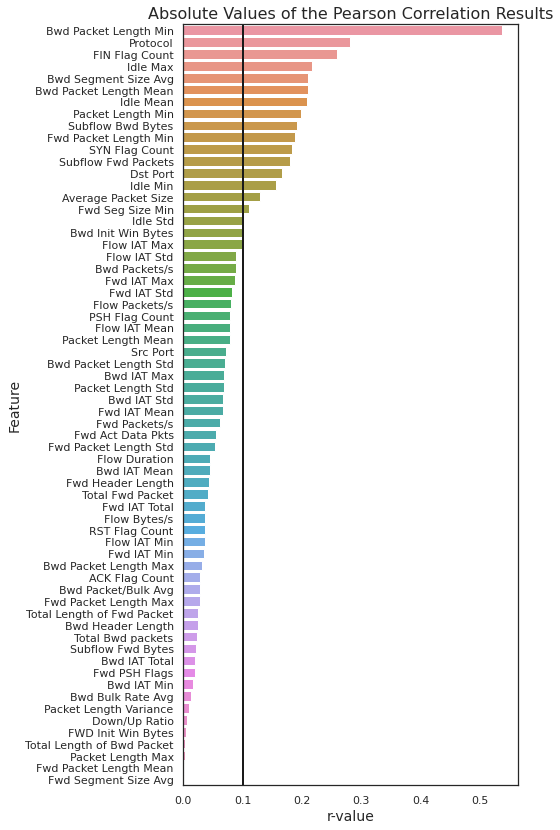

In [31]:
plt.figure(figsize=(6,14))
plt.title("Absolute Values of the Pearson Correlation Results", fontsize=16)

sns.barplot(x=pears_X['r-value'], y=pears_X.index)
plt.xlabel('r-value', fontsize=14)
plt.ylabel('Feature' ,fontsize=14)

plt.axvline(x=0.1,linewidth=2, color='k')

In [32]:
# from sklearn.linear_model import LogisticRegression
# from sklearn import tree
# from sklearn.ensemble import RandomForestClassifier
# from random import sample

In [33]:
# # Here, we are showing how each feature's importance to the random forest

# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# importance = sorted(zip(map(lambda x: round(x, 4),
#                             rf.feature_importances_), X_train), reverse=True)

In [34]:
# # Now, we plot the importance to see which columns we want to keep

# labels = [row[1] for row in importance]
# info = [row[0] for row in importance]
# plt.figure(figsize=(8,14))
# plt.title('Feature Importance')
# sns.barplot(x = info, y= labels)

## Selecting Columns

In [35]:
# temp = df.copy(deep=True)

In [36]:
# top = 40

# top_features = [x for x in p_vals.index[:top] if x in  r_vals.index[:top]]
# print(len(top_features))

# X = temp[top_features]

# Feature Distribution

In [37]:
# data_col = np.transpose(X.columns).to_list()
# df['Label_dark'] = df['Label_dark'].apply(lambda x: 'Darknet' if x == 1 else 'Non-Darknet')

In [38]:
# for col in data_col:
#   g = sns.displot(data=df, x=col, col='Label_dark',bins=30, height=4, aspect=1.4)
#   g.set_titles('{col_name}')
#   g.tight_layout()

# Train vs. Test

In [39]:
X.to_csv(r'/content/drive/My Drive/Code/cleaned_X.csv', index=False)
y.to_csv(r'/content/drive/My Drive/Code/cleaned_y.csv', index=False)

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
# Splitting into training and testing data sets

X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2, random_state=1)


In [42]:
# Now, splitting into classification labels and data
y_train = y_train['Label_dark']
y_test = y_test['Label_dark']

Build and Evaluate Models

In [43]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [44]:
def runExperiments(X_train, Y_train):
    random_seed = 100
    scoring = 'accuracy'
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='auto')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('AB', AdaBoostClassifier(n_estimators=100)))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=10)))

    # evaluate each model in turn using 10-fold cross-validation
    results = []
    classifiers = []
    accuracies = []
    for classifier, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=random_seed)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        accuracies.append((cv_results.mean(), classifier))
        results.append(cv_results)
        classifiers.append(classifier)
        msg = "%s: %f (%f)" % (classifier, cv_results.mean(), cv_results.std())
        print(msg)
    return results, accuracies, classifiers

In [45]:
#results, accuracies, classifiers = runExperiments(X_train, y_train)


# Classification

## Steps
1. Initialize the classifier
2. Train the classifier
3. Predict the target
4. Evaluate, find error

In [46]:
accuracy = []
tests = []

## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression(random_state=0, solver='sag')
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

In [48]:
accuracy.append(metrics.accuracy_score(y_test, lr_pred))
tests.append('Logistical Regression')

print('Accuracy of training data', lr.score(X_train, y_train))
print('Accuracy of testing data ', metrics.accuracy_score(y_test, lr_pred), end='\n\n')
print(metrics.confusion_matrix(y_test, lr_pred), end='\n\n')
print(metrics.classification_report(y_test, lr_pred))

Accuracy of training data 0.6490776444952413
Accuracy of testing data  0.6464430677205725

[[13567  5117]
 [ 3158  1563]]

              precision    recall  f1-score   support

           0       0.81      0.73      0.77     18684
           1       0.23      0.33      0.27      4721

    accuracy                           0.65     23405
   macro avg       0.52      0.53      0.52     23405
weighted avg       0.69      0.65      0.67     23405



## Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train , y_train)

rf_pred = rf.predict(X_test)  

In [50]:
accuracy.append(metrics.accuracy_score(y_test, rf_pred))
tests.append('Random Forest')

print('Accuracy of training data', rf.score(X_train, y_train))
print('Accuracy of testing data ', metrics.accuracy_score(y_test, rf_pred), end='\n\n')
print(metrics.confusion_matrix(y_test, rf_pred), end='\n\n')
print(metrics.classification_report(y_test, rf_pred))

Accuracy of training data 0.9999359104455292
Accuracy of testing data  0.981115146336253

[[18484   200]
 [  242  4479]]

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18684
           1       0.96      0.95      0.95      4721

    accuracy                           0.98     23405
   macro avg       0.97      0.97      0.97     23405
weighted avg       0.98      0.98      0.98     23405



## Gradient Boosting

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train , y_train)

gb_pred = gb.predict(X_test)

In [52]:
accuracy.append(metrics.accuracy_score(y_test, gb_pred))
tests.append('Gradient Boosting')

print('Accuracy of training data', gb.score(X_train, y_train))
print('Accuracy of testing data ', metrics.accuracy_score(y_test, gb_pred), end='\n\n')
print(metrics.confusion_matrix(y_test, gb_pred), end='\n\n')
print(metrics.classification_report(y_test, gb_pred))

Accuracy of training data 0.9690554267830248
Accuracy of testing data  0.9669728690450758

[[18399   285]
 [  488  4233]]

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18684
           1       0.94      0.90      0.92      4721

    accuracy                           0.97     23405
   macro avg       0.96      0.94      0.95     23405
weighted avg       0.97      0.97      0.97     23405



## Ada Boost

In [53]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X_train , y_train)

ada_pred = ada.predict(X_test)

In [54]:
accuracy.append(metrics.accuracy_score(y_test, ada_pred))
tests.append('Ada Boost')

print('Accuracy of training data', ada.score(X_train, y_train))
print('Accuracy of testing data ', metrics.accuracy_score(y_test, ada_pred), end='\n\n')
print(metrics.confusion_matrix(y_test, ada_pred), end='\n\n')
print(metrics.classification_report(y_test, ada_pred))

Accuracy of training data 0.9435264209188305
Accuracy of testing data  0.9410382396923734

[[18105   579]
 [  801  3920]]

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     18684
           1       0.87      0.83      0.85      4721

    accuracy                           0.94     23405
   macro avg       0.91      0.90      0.91     23405
weighted avg       0.94      0.94      0.94     23405



## K-Nearest Neighbors

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [56]:
accuracy.append(metrics.accuracy_score(y_test, knn_pred))
tests.append('K-Nearest Neighbors')

print('Accuracy of training data', ada.score(X_train, y_train))
print('Accuracy of testing data ', metrics.accuracy_score(y_test, knn_pred), end='\n\n')
print(metrics.confusion_matrix(y_test, knn_pred), end='\n\n')
print(metrics.classification_report(y_test, knn_pred))

Accuracy of training data 0.9435264209188305
Accuracy of testing data  0.9604358043153173

[[18362   322]
 [  604  4117]]

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18684
           1       0.93      0.87      0.90      4721

    accuracy                           0.96     23405
   macro avg       0.95      0.93      0.94     23405
weighted avg       0.96      0.96      0.96     23405



## SGD Classifier

In [57]:
from sklearn.linear_model import SGDClassifier

sdg = SGDClassifier()
sdg.fit(X_train, y_train)

sdg_pred = sdg.predict(X_test)

In [58]:
accuracy.append(metrics.accuracy_score(y_test, sdg_pred))
tests.append('SDG Classifier')

print('Accuracy of training data', sdg.score(X_train, y_train))
print('Accuracy of testing data ', metrics.accuracy_score(y_test, sdg_pred), end='\n\n')
print(metrics.confusion_matrix(y_test, sdg_pred), end='\n\n')
print(metrics.classification_report(y_test, sdg_pred))

Accuracy of training data 0.6930858052318439
Accuracy of testing data  0.6919888912625507

[[13166  5518]
 [ 1691  3030]]

              precision    recall  f1-score   support

           0       0.89      0.70      0.79     18684
           1       0.35      0.64      0.46      4721

    accuracy                           0.69     23405
   macro avg       0.62      0.67      0.62     23405
weighted avg       0.78      0.69      0.72     23405



# Results


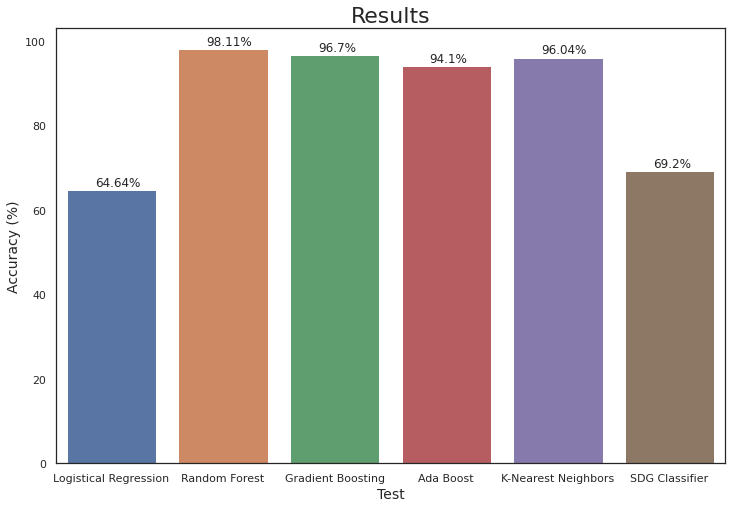

In [59]:
plt.figure(figsize=(len(accuracy)*2,8))
sns.barplot(x=tests, y=[100*x for x in accuracy])
plt.title('Results', fontsize = 22)
plt.xlabel('Test', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
for i in range(len(accuracy)):
  plt.text(i-.15,accuracy[i]*100+1,str(round(accuracy[i]*100,2))+'%')

Binary classification

Make Predictions using Random Forest(RF)




*   RF provides maximum accuracy result over all the classifiers
*   check the accuracy of the best model using validation set



In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def testBestModel(model, X_validation, Y_validation):
    # make predictions on validation dataset
    Y_predictions = rf.predict(X_validation)
    print("Accuracy = {:.2f}".format(accuracy_score(Y_validation, Y_predictions)))
    print('Confusion Matrix:')
    print(confusion_matrix(Y_validation, Y_predictions))
    print('Classification Report:')
    print(classification_report(Y_validation, Y_predictions))
    return Y_predictions

In [61]:
# train the best model and find the validation accuracy
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_predictions = testBestModel(rf, X_test, y_test)

Accuracy = 0.98
Confusion Matrix:
[[18480   204]
 [  279  4442]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18684
           1       0.96      0.94      0.95      4721

    accuracy                           0.98     23405
   macro avg       0.97      0.96      0.97     23405
weighted avg       0.98      0.98      0.98     23405

